Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


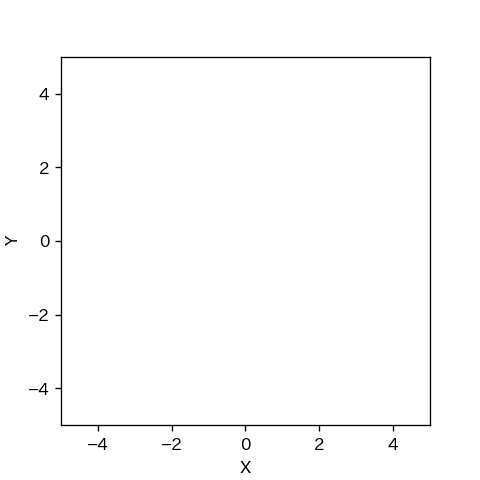

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


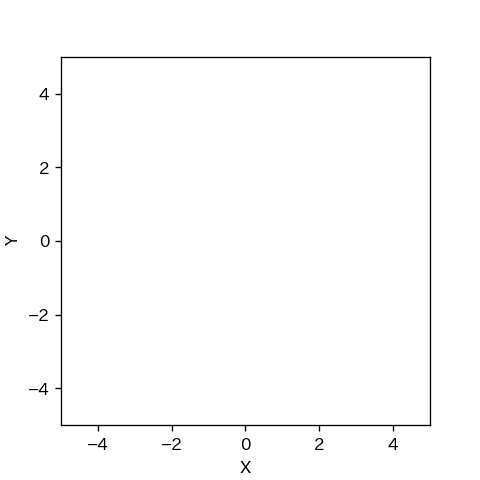

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [-0.93106326  1.89041544  3.98985518] 推定値: [-1.37313965  2.07412157  4.08544751] 誤差: 0.4787269343375356
1
1 真値: [0.37677691 2.45108409 2.82120751] 推定値: [0.42682892 2.56516993 2.8849511 ] 誤差: 0.1245824350640821
2
2 真値: [1.24329773 1.64153664 1.81765913] 推定値: [-0.08828384  0.9258192   4.99375073] 誤差: 1.511741023714796
3 真値: [-0.40909639  1.70805477  3.39350017] 推定値: [-1.25515583  2.4038047   3.61788575] 誤差: 1.0953924182826869
4 真値: [0.33489234 2.03081172 2.6079665 ] 推定値: [0.00933742 1.65381183 2.51410054] 誤差: 0.49811135865007033
3
5 真値: [-0.62701369  2.44955766  3.49549113] 推定値: [-1.01674897  2.41390209  3.50512236] 誤差: 0.39136288776969586
4
6 真値: [1.08662511 1.87167333 2.1050842 ] 推定値: [0.9121054  2.31403827 2.206803  ] 誤差: 0.47554586856235254
5
7 真値: [-0.73560213  1.71025212  3.71622563] 推定値: [-1.02602957  2.22374038  3.85149832] 誤差: 0.5899307511907507
6
8 真値: [-0.75680768  2.63648004  3.84519002] 推定値: [-0.38607723  2.61526149  3.80700344] 誤差: 0.3713371694891823
7
9 真値: [0.486331

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.95381331 1.27252175 1.70231755] 推定値: [1.01594664 1.52695805 1.62262325] 誤差: 0.2619129248294364
14
21 真値: [1.04539645 1.43494687 1.9981992 ] 推定値: [1.01681523 1.33415221 2.10411801] 誤差: 0.10476855407342023
15
22 真値: [1.12935915 1.950895   2.1346408 ] 推定値: [0.64967758 2.79843592 2.42773719] 誤差: 0.9738685851078355
16
23 真値: [0.4864011  1.26861863 2.19181862] 推定値: [-0.16443138  2.46450547  2.49234863] 誤差: 1.3615168876701138
24 真値: [0.48936196 2.25845359 2.95287942] 推定値: [0.56279174 2.24960136 3.05074303] 誤差: 0.07396143721013107
17
25 真値: [-0.04027906  2.40254154  3.25353278] 推定値: [0.65344538 1.78306356 3.15419553] 誤差: 0.9300572921766457
18
26 真値: [-0.33195624  2.17270006  3.35414421] 推定値: [-0.6481943   1.50661539  3.1561876 ] 誤差: 0.7373433967891452
19
27 真値: [0.91779849 1.76002924 2.26427613] 推定値: [0.6435081  1.60210353 2.29761504] 誤差: 0.3165055327141332
20
28 真値: [-0.75670582  0.62505286  5.06890644] 推定値: [-0.93255399  0.03387508  5.18929195] 誤差: 0.6167769046617743
21
29 真値: [0.5